**The full code will run locally without any modification (You can also put  https://huggingface.co/microsoft/deberta-v3-base downloaded file below, not mendatory)**

In [3]:
ModelName = 'microsoft/deberta-v3-base'

# **Install and Import Python Libraries**

In [4]:
%pip install transformers[torch]
%pip install transformers
%pip install evaluate
%pip install scikit-learn
%pip install matplotlib
%pip install wordcloud
%pip install sentencepiece
%pip install protobuf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd

# EDA
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Model
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback

# dataset
from torch.utils.data import Dataset

# performance evaluation
import evaluate
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

# **Load data**

In [6]:
df = pd.read_csv("dataset.csv")
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


# **Common Functions for Both Tasks**

### **Tokenizer from pretrained model**

In [7]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(ModelName)

# Take a look at the tokenizer
tokenizer

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### **Convert text into embedding vectors**

In [8]:
# Convert text into embedding vectors
def tokenize_dataset(tokenizer, texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=48)
    inputs["labels"] = torch.tensor(labels)
    return inputs

### **Convert encodings to PyTorch tensors**

In [10]:
# Convert encodings to PyTorch tensors
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])

### **Compute Metrics**

In [11]:
# Load metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# set evaluation metrics
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  # Calculate both accuracy and F1-score
  return {"Accuracy": accuracy.compute(predictions=predictions, references=labels),
          "F1 Score": f1.compute(predictions=predictions, references=labels, average="macro")}

# **TASK A**

### **Read Data for Task A and EDA**

In [9]:
# Create a copy for task A
dfA = df.copy()
dfA.drop(columns=['rewire_id', 'label_category', 'label_vector'], inplace=True)
dfA.head()

,text,label_sexist
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist
2,How the FUCK is this woman still an MP!!!???,not sexist
3,Understand. Know you're right. At same time I ...,not sexist
4,Surprized they didn't stop and rape some women,not sexist


In [10]:
dfA.shape

(14000, 2)

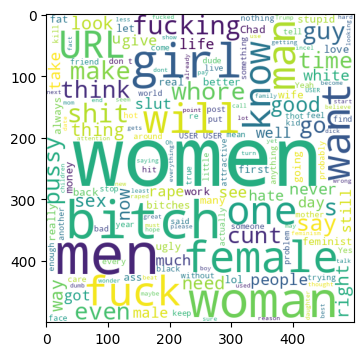

In [11]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['label_sexist'] == 'sexist']['text'].str.cat(sep=" "))
plt.figure(figsize=(8,4))
plt.imshow(spam_wc)

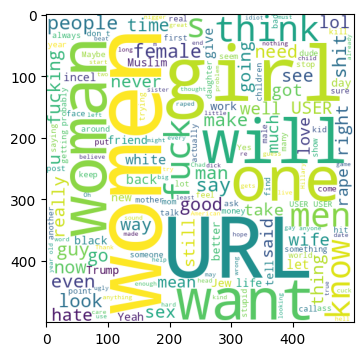

In [12]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['label_sexist'] == 'not sexist']['text'].str.cat(sep=" "))
plt.figure(figsize=(8,4))
plt.imshow(spam_wc)

<Axes: ylabel='label_sexist'>

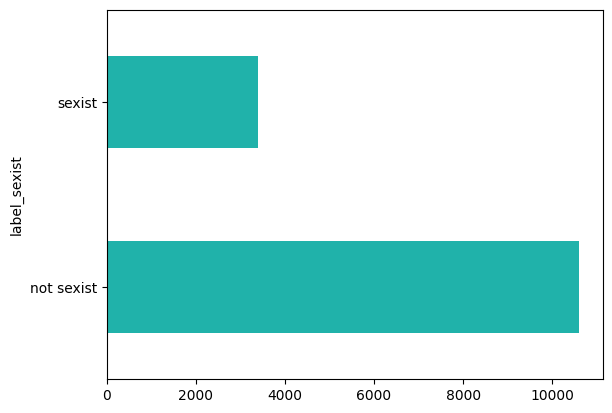

In [13]:
dfA['label_sexist'].value_counts().plot.barh(color='LightSeaGreen')
# dataset is imbalance

In [14]:
# Get the dataset information
dfA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          14000 non-null  object
 1   label_sexist  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [15]:
# Check the label distribution
dfA['label_sexist'].value_counts()

label_sexist
not sexist    10602
sexist         3398
Name: count, dtype: int64

In [16]:
# check class distribution
dfA['label_sexist'].value_counts(normalize = True)

label_sexist
not sexist    0.757286
sexist        0.242714
Name: proportion, dtype: float64

### **Data Splitting**

In [17]:
train, val = train_test_split(dfA, test_size = 0.2, random_state = 1000, stratify = dfA.label_sexist)
val, test = train_test_split(val, test_size = 0.5, random_state = 100, stratify = val.label_sexist)

In [18]:
print('train:', len(train))
print('val:', len(val))
print('test:', len(test))

train: 11200
val: 1400
test: 1400


In [19]:
print('train', train['label_sexist'].value_counts())
print('val', val['label_sexist'].value_counts())
print('test', test['label_sexist'].value_counts())

train label_sexist
not sexist    8482
sexist        2718
Name: count, dtype: int64
val label_sexist
not sexist    1060
sexist         340
Name: count, dtype: int64
test label_sexist
not sexist    1060
sexist         340
Name: count, dtype: int64


In [20]:
train["label_sexist"] = train["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
val["label_sexist"] = val["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
test["label_sexist"] = test["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()

In [21]:
X_train = train["text"].tolist()
y_train = train["label_sexist"].tolist()

X_val = val["text"].tolist()
y_val = val["label_sexist"].tolist()

X_test = test["text"].tolist()
y_test = test["label_sexist"].tolist()

### **Converts Text into an Embedding Vector**

In [22]:
train_encodings = tokenize_dataset(tokenizer, X_train, y_train)
val_encodings = tokenize_dataset(tokenizer, X_val, y_val)

In [23]:
train_encodings

{'input_ids': tensor([[    1, 20671,   287,  ...,     0,     0,     0],
        [    1, 33879,   504,  ...,     0,     0,     0],
        [    1,  1124, 19555,  ...,     0,     0,     0],
        ...,
        [    1,   307,  8000,  ...,     0,     0,     0],
        [    1,   647, 11698,  ...,     0,     0,     0],
        [    1,   367,   348,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 0,  ..., 0, 0, 0])}

In [24]:
# Convert encodings to PyTorch tensors
trainingDataset = Dataset(train_encodings)
valDataset = Dataset(val_encodings)

In [25]:
trainingDataset

### **Load Pretrained Model**

In [26]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(ModelName, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Set Training Argument**

In [27]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./resultA/",
    logging_dir='./resultA/logs',
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-6,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

### **Train the model**

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

training_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,0.561800,0.492742,{'accuracy': 0.7571428571428571},{'f1': 0.43089430894308944}
2,0.457900,0.430054,{'accuracy': 0.8271428571428572},{'f1': 0.7167517748995923}
3,0.399200,0.380849,{'accuracy': 0.84},{'f1': 0.7779665817048995}
4,0.361900,0.374051,{'accuracy': 0.855},{'f1': 0.8014629706085558}
5,0.351600,0.370398,{'accuracy': 0.8585714285714285},{'f1': 0.8065494052720172}
6,0.332200,0.386197,{'accuracy': 0.8642857142857143},{'f1': 0.804987624778595}


Trainer is attempting to log a value of "{'accuracy': 0.7571428571428571}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.43089430894308944}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8271428571428572}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7167517748995923}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.84}" of type <class 'dict'> for

### **Model Performance Evaluation**

In [29]:
trainer.state.log_history

[{'loss': 0.5618,
  'grad_norm': 8.51005744934082,
  'learning_rate': 9e-07,
  'epoch': 1.0,
  'step': 1400},
 {'eval_loss': 0.49274206161499023,
  'eval_Accuracy': {'accuracy': 0.7571428571428571},
  'eval_F1 Score': {'f1': 0.43089430894308944},
  'eval_runtime': 6.0563,
  'eval_samples_per_second': 231.163,
  'eval_steps_per_second': 28.895,
  'epoch': 1.0,
  'step': 1400},
 {'loss': 0.4579,
  'grad_norm': 6.4539666175842285,
  'learning_rate': 8e-07,
  'epoch': 2.0,
  'step': 2800},
 {'eval_loss': 0.43005362153053284,
  'eval_Accuracy': {'accuracy': 0.8271428571428572},
  'eval_F1 Score': {'f1': 0.7167517748995923},
  'eval_runtime': 5.7829,
  'eval_samples_per_second': 242.095,
  'eval_steps_per_second': 30.262,
  'epoch': 2.0,
  'step': 2800},
 {'loss': 0.3992,
  'grad_norm': 15.24267864227295,
  'learning_rate': 7e-07,
  'epoch': 3.0,
  'step': 4200},
 {'eval_loss': 0.3808485269546509,
  'eval_Accuracy': {'accuracy': 0.84},
  'eval_F1 Score': {'f1': 0.7779665817048995},
  'eval_r

[0.5618, 0.4579, 0.3992, 0.3619, 0.3516, 0.3322]
[0.49274206161499023, 0.43005362153053284, 0.3808485269546509, 0.3740505576133728, 0.37039804458618164, 0.3861973285675049]


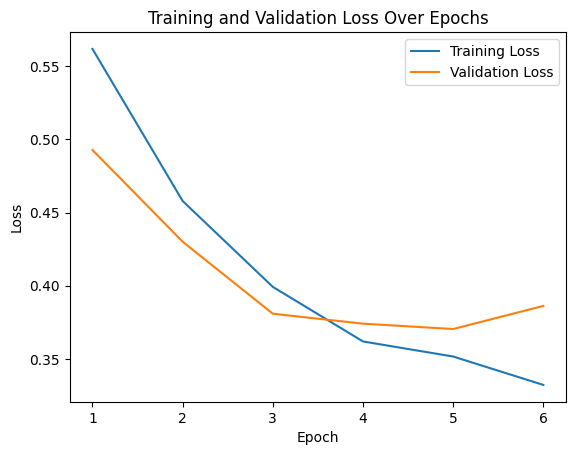

In [30]:
# Extract loss values and epochs from the log history
training_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
validation_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]
epochs = [entry['epoch'] for entry in trainer.state.log_history if 'epoch' in entry]
print(training_losses)
print(validation_losses)
epochs = list(set(epochs))

# Plot the loss graph
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [31]:
trainer.evaluate(trainingDataset)

Trainer is attempting to log a value of "{'accuracy': 0.8835714285714286}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8374046301917228}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.30799466371536255,
 'eval_Accuracy': {'accuracy': 0.8835714285714286},
 'eval_F1 Score': {'f1': 0.8374046301917228},
 'eval_runtime': 53.9134,
 'eval_samples_per_second': 207.741,
 'eval_steps_per_second': 25.968,
 'epoch': 6.0}

In [32]:
trainer.evaluate(valDataset)

Trainer is attempting to log a value of "{'accuracy': 0.8585714285714285}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8065494052720172}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.37039804458618164,
 'eval_Accuracy': {'accuracy': 0.8585714285714285},
 'eval_F1 Score': {'f1': 0.8065494052720172},
 'eval_runtime': 6.3465,
 'eval_samples_per_second': 220.594,
 'eval_steps_per_second': 27.574,
 'epoch': 6.0}

In [33]:
predictions, _, _ = trainer.predict(valDataset)
predictions = np.argmax(predictions, axis = 1)

In [34]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1060
           1       0.71      0.70      0.71       340

    accuracy                           0.86      1400
   macro avg       0.81      0.80      0.81      1400
weighted avg       0.86      0.86      0.86      1400



### **Testing**

In [45]:
# Actual Label
print(X_test[:5])
y_test[:5]

["Simba and Nala were cousins but that doesn't mean the Lion King is promoting incest jfc", 'Oh wait its a woman. Figures Take it easy on the sexism, man. Not a great look for you or this sub.', 'I would support this, 100%. Anti-Brexit businesses should feel the pain of not being supported by anyone involved with our beautiful movement. They are trying to stop us. They are our enemy.', '[URL] Funny how NOT ONE MP wanted Naz Shah to be investigated after her disgusting tweet telling the rape victims of Rotherham to shut up for the good of diversity #BritFam #GabFam #SpeakFreely', "I love how they pretend to give a damm about babies when really they just want to control women's bodies, remove any rights women have, and just have another excuse to hate women. They've no real conviction and it's just boring."]


[0, 0, 0, 0, 0]

In [46]:
# tokenization
test_encodings = tokenize_dataset(tokenizer, X_test, y_test)
# Convert encodings to PyTorch tensors
testingDataset = Dataset(test_encodings)
# Trainer evaluate
trainer.evaluate(testingDataset)

Trainer is attempting to log a value of "{'accuracy': 0.8528571428571429}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7913773148148149}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.39094603061676025,
 'eval_Accuracy': {'accuracy': 0.8528571428571429},
 'eval_F1 Score': {'f1': 0.7913773148148149},
 'eval_runtime': 5.9848,
 'eval_samples_per_second': 233.925,
 'eval_steps_per_second': 29.241,
 'epoch': 6.0}

In [47]:
predictions, _, _ = trainer.predict(testingDataset)
predictions = np.argmax(predictions, axis = 1)
# Predicted Label
predictions[:5]

array([0, 0, 0, 0, 1])

# **Task B**

### **Read Data for Task B and EDA**

In [ ]:
# Create a copy for task B
dfB = df.copy()
dfB.drop(columns=['rewire_id', 'label_sexist',  'label_vector'], inplace=True)
dfB = dfB[df['label_category'] != 'none']
dfB.head()

,text,label_category
8,"just the inside of your wallet: cash, bank car...",2. derogation
11,They get the initial chance because they are a...,2. derogation
17,ugly chicks A pussy is a pussy.,2. derogation
18,fuck her off with a nine mm this is what you g...,"1. threats, plans to harm and incitement"
19,How about I talk shit to an idiot like you? Ar...,3. animosity


In [ ]:
dfB.shape

(3398, 2)

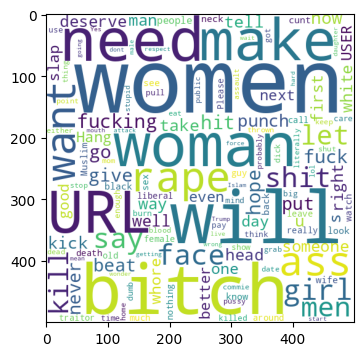

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['label_category'] == "1. threats, plans to harm and incitement"]['text'].str.cat(sep=" "))
plt.figure(figsize=(8,4))
plt.imshow(spam_wc)

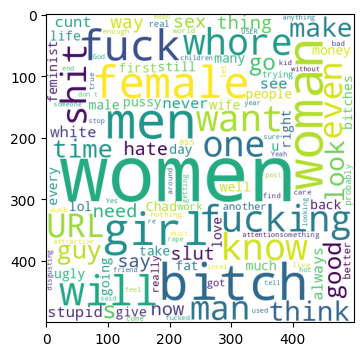

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df["label_category"] == '2. derogation']['text'].str.cat(sep=" "))
plt.figure(figsize=(8,4))
plt.imshow(spam_wc)

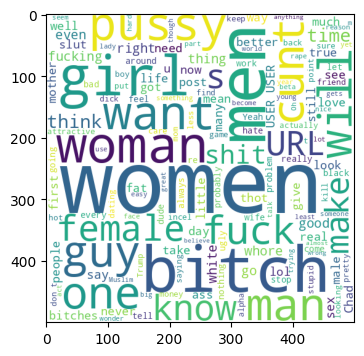

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df["label_category"] == '3. animosity']['text'].str.cat(sep=" "))
plt.figure(figsize=(8,4))
plt.imshow(spam_wc)

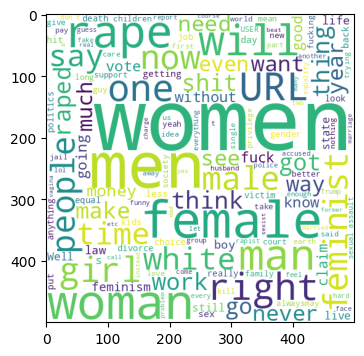

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df["label_category"] == '4. prejudiced discussions']['text'].str.cat(sep=" "))
plt.figure(figsize=(8,4))
plt.imshow(spam_wc)

<Axes: ylabel='label_category'>

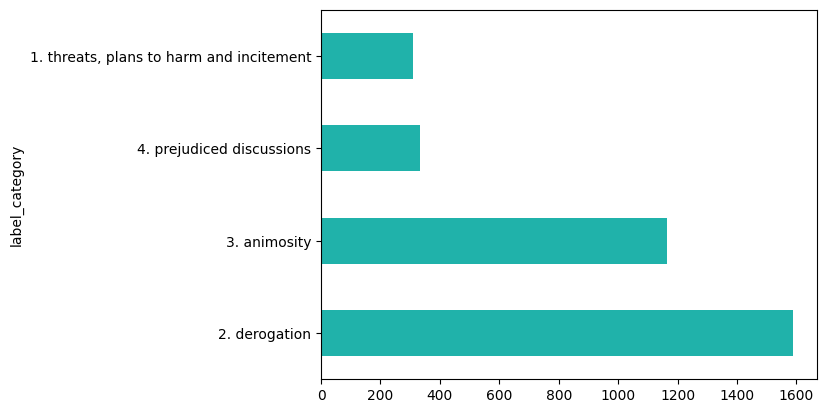

In [ ]:
dfB['label_category'].value_counts().plot.barh(color='LightSeaGreen')

In [ ]:
# Get the dataset information
dfB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 8 to 13995
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            3398 non-null   object
 1   label_category  3398 non-null   object
dtypes: object(2)
memory usage: 79.6+ KB


In [ ]:
# check class distribution
dfB['label_category'].value_counts(normalize = True)

label_category
2. derogation                               0.467922
3. animosity                                0.342849
4. prejudiced discussions                   0.097999
1. threats, plans to harm and incitement    0.091230
Name: proportion, dtype: float64

In [ ]:
# Check the label distribution
dfB['label_category'].value_counts()

label_category
2. derogation                               1590
3. animosity                                1165
4. prejudiced discussions                    333
1. threats, plans to harm and incitement     310
Name: count, dtype: int64

### **Data Splitting**

In [ ]:
train, val = train_test_split(dfB, test_size = 0.2, random_state = 1000, stratify = dfB.label_category)
val, test = train_test_split(val, test_size = 0.5, random_state = 100, stratify = val.label_category)

In [ ]:
print('train:', len(train))
print('val:', len(val))
print('test:', len(test))

train: 2718
val: 340
test: 340


In [ ]:
print('train', train['label_category'].value_counts())
print('val', val['label_category'].value_counts())
print('test', test['label_category'].value_counts())

train label_category
2. derogation                               1272
3. animosity                                 932
4. prejudiced discussions                    266
1. threats, plans to harm and incitement     248
Name: count, dtype: int64
val label_category
2. derogation                               159
3. animosity                                116
4. prejudiced discussions                    34
1. threats, plans to harm and incitement     31
Name: count, dtype: int64
test label_category
2. derogation                               159
3. animosity                                117
4. prejudiced discussions                    33
1. threats, plans to harm and incitement     31
Name: count, dtype: int64


In [ ]:
label_map = {
    "1. threats, plans to harm and incitement": 0,
    "2. derogation": 1,
    "3. animosity": 2,
    "4. prejudiced discussions": 3
}

train["label_category"] = train["label_category"].map(label_map).tolist()
val["label_category"] = val["label_category"].map(label_map).tolist()
test["label_category"] = test["label_category"].map(label_map).tolist()

In [ ]:
train.head()

,text,label_category
10631,Men work on preserving their financial positio...,2
4512,She’s nuts she needs to be locked up preferabl...,0
4691,"Bulletproof, I just got that.... you clearly n...",2
8,"just the inside of your wallet: cash, bank car...",1
2787,Women hate vulnerable men,1


In [ ]:
X_train = train["text"].tolist()
y_train = train["label_category"].tolist()

X_val = val["text"].tolist()
y_val = val["label_category"].tolist()

X_test = test["text"].tolist()
y_test = test["label_category"].tolist()

### **Converts Text into an Embedding Vector**

In [ ]:
train_encodings = tokenize_dataset(tokenizer, X_train, y_train)
val_encodings = tokenize_dataset(tokenizer, X_val, y_val)

In [ ]:
train_encodings

{'input_ids': tensor([[     1,   3580,    374,  ...,      0,      0,      0],
        [     1,    503,    276,  ...,      0,      0,      0],
        [     1, 101714,    261,  ...,      0,      0,      0],
        ...,
        [     1,   6191,    833,  ...,      0,      0,      0],
        [     1,    502,    282,  ...,      0,      0,      0],
        [     1,   1448,    276,  ...,   1550,  14034,      2]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([2, 0, 2,  ..., 1, 1, 2])}

In [ ]:
# Convert encodings to PyTorch tensors
trainingDataset = Dataset(train_encodings)
valDataset = Dataset(val_encodings)

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(ModelName, num_labels=4, ignore_mismatched_sizes=True)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Set Training Argument**

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./resultB/",
    logging_dir='./resultB/logs',
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-6,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

### **Train the model**

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

training_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,1.156200,1.045606,{'accuracy': 0.4676470588235294},{'f1': 0.1593186372745491}
2,1.015300,0.945586,{'accuracy': 0.6088235294117647},{'f1': 0.4526816826565245}
3,0.818700,0.845880,{'accuracy': 0.6441176470588236},{'f1': 0.6335738539898133}
4,0.665900,0.880251,{'accuracy': 0.6647058823529411},{'f1': 0.6378576649958229}


Trainer is attempting to log a value of "{'accuracy': 0.4676470588235294}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.1593186372745491}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6088235294117647}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.4526816826565245}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6441176470588236}" of type <clas

### **Model Performance Evaluation**

In [ ]:
trainer.state.log_history

[{'loss': 1.1562,
  'grad_norm': 14.971272468566895,
  'learning_rate': 4.5e-06,
  'epoch': 1.0,
  'step': 680},
 {'eval_loss': 1.0456063747406006,
  'eval_Accuracy': {'accuracy': 0.4676470588235294},
  'eval_F1 Score': {'f1': 0.1593186372745491},
  'eval_runtime': 4.0414,
  'eval_samples_per_second': 84.129,
  'eval_steps_per_second': 21.032,
  'epoch': 1.0,
  'step': 680},
 {'loss': 1.0153,
  'grad_norm': 14.850508689880371,
  'learning_rate': 4.000000000000001e-06,
  'epoch': 2.0,
  'step': 1360},
 {'eval_loss': 0.9455864429473877,
  'eval_Accuracy': {'accuracy': 0.6088235294117647},
  'eval_F1 Score': {'f1': 0.4526816826565245},
  'eval_runtime': 5.528,
  'eval_samples_per_second': 61.505,
  'eval_steps_per_second': 15.376,
  'epoch': 2.0,
  'step': 1360},
 {'loss': 0.8187,
  'grad_norm': 46.05058288574219,
  'learning_rate': 3.5e-06,
  'epoch': 3.0,
  'step': 2040},
 {'eval_loss': 0.8458801507949829,
  'eval_Accuracy': {'accuracy': 0.6441176470588236},
  'eval_F1 Score': {'f1': 0.

[1.1562, 1.0153, 0.8187, 0.6659]
[1.0456063747406006, 0.9455864429473877, 0.8458801507949829, 0.8802513480186462, 0.5996776223182678, 0.8458801507949829, 0.9542948007583618]


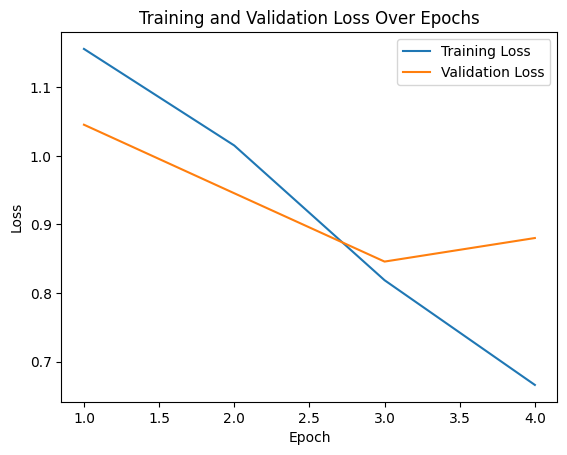

In [ ]:
# Extract loss values and epochs from the log history
training_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
validation_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]
epochs = [entry['epoch'] for entry in trainer.state.log_history if 'epoch' in entry]
print(training_losses)
print(validation_losses)
epochs = list(set(epochs))

# Plot the loss graph
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses[:4], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
trainer.evaluate(trainingDataset)

Trainer is attempting to log a value of "{'accuracy': 0.7729948491537896}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7604380428760176}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5996776223182678,
 'eval_Accuracy': {'accuracy': 0.7729948491537896},
 'eval_F1 Score': {'f1': 0.7604380428760176},
 'eval_runtime': 29.5281,
 'eval_samples_per_second': 92.048,
 'eval_steps_per_second': 23.029,
 'epoch': 4.0}

In [ ]:
trainer.evaluate(valDataset)

Trainer is attempting to log a value of "{'accuracy': 0.6441176470588236}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6335738539898133}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8458801507949829,
 'eval_Accuracy': {'accuracy': 0.6441176470588236},
 'eval_F1 Score': {'f1': 0.6335738539898133},
 'eval_runtime': 2.3551,
 'eval_samples_per_second': 144.367,
 'eval_steps_per_second': 36.092,
 'epoch': 4.0}

In [ ]:
predictions, _, _ = trainer.predict(valDataset)
predictions = np.argmax(predictions, axis = 1)
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65        31
           1       0.70      0.67      0.68       159
           2       0.62      0.59      0.61       116
           3       0.52      0.71      0.60        34

    accuracy                           0.64       340
   macro avg       0.62      0.65      0.63       340
weighted avg       0.65      0.64      0.65       340



### **Testing**

In [ ]:
X_test[:5]
# Actual Label
y_test[:5]

[1, 1, 1, 2, 2]

In [ ]:
test_encodings = tokenize_dataset(tokenizer, X_test, y_test)
# Convert encodings to PyTorch tensors
testingDataset = Dataset(test_encodings)
# Trainer evaluate
trainer.evaluate(testingDataset)

Trainer is attempting to log a value of "{'accuracy': 0.5676470588235294}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5733307851898763}" of type <class 'dict'> for key "eval/F1 Score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9542948007583618,
 'eval_Accuracy': {'accuracy': 0.5676470588235294},
 'eval_F1 Score': {'f1': 0.5733307851898763},
 'eval_runtime': 2.1836,
 'eval_samples_per_second': 155.707,
 'eval_steps_per_second': 38.927,
 'epoch': 4.0}

In [ ]:
predictions, _, _ = trainer.predict(testingDataset)
predictions = np.argmax(predictions, axis = 1)
# Predicted Label
predictions[:5]

array([1, 3, 3, 1, 3])